In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

from Bscan_migration_v3 import Bscan_migration_v3
from Scan import Scan

data_source_dir = 'data'
data_source_fn = '50ps_1_data.mat'

with h5py.File(os.path.join(data_source_dir, data_source_fn), 'r') as f:
    Data = f['Data'][:].T
    DataBKGR = f['DataBKGR'][:].T
    x = f['x'][:]
    t = f['t'][:]

Data.shape, x.shape, t.shape, DataBKGR.shape

((1023, 256), (256, 1), (1023, 1), (1023, 256))

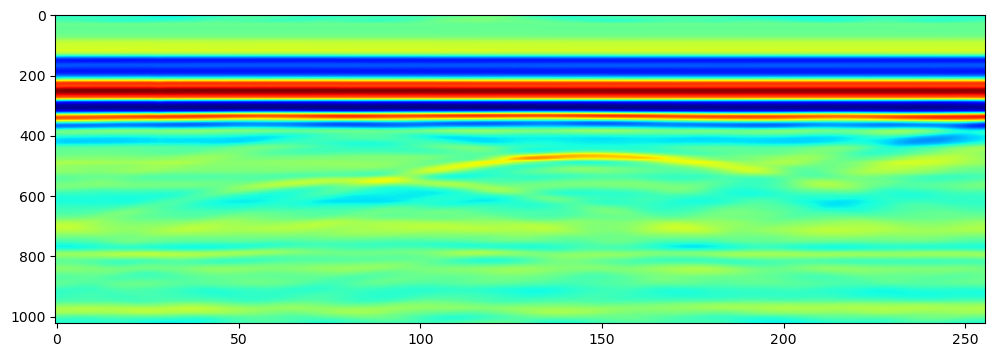

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.imshow(Data, aspect='auto', cmap='jet')
plt.show()

In [20]:
S = Scan(Data, x, t)
S.__dict__.keys()

dict_keys(['Data', 'x', 'dx', 'Kx', 'Nx', 'kx', 't', 'Ts', 'Fs', 'Nt', 'f'])

In [22]:
Data.shape, x.shape, t.shape

((1023, 256), (256, 1), (1023, 1))

In [28]:
# 设置迁移参数

h = 21.59e-2         # 天线离地面的高度
# h = 0.
tx_dx = 3e-2         # 发射天线距离阵列中心的水平距离
rx_dx = -3e-2        # 接收天线距离阵列中心的水平距离
er = 5               # 地面介电常数

dt = 1.3e-9          # t0在哪里，真的吗？
compensate_dt = 1    # 是否要补偿t0？（推荐）

# 设置变量
S.h = h
S.tx_pos = tx_dx
S.rx_pos = rx_dx
S.er = er
S.t = S.t - compensate_dt * dt

# 计算向量
Nx = 512
Nz = 256
xC = np.linspace(0, np.max(S.x), Nx)
zC = np.linspace(0, 40e-2, Nz)

# display 0: 不显示进度条; 1: 显示进度条
display_progress_bar = 0

S.BKGR_MEAN()

S.DataBKGR.shape, S.h, S.er, S.t.shape, S.x.shape, S.tx_pos, S.rx_pos, xC.shape, zC.shape


((1023, 256), 0.0, 5, (1023, 1), (256, 1), 0.03, -0.03, (512,), (256,))

In [29]:
def normalize(img):
    return img / np.max(np.abs(img))

# 执行迁移成像
S.migrate(xC, zC, display_progress_bar)

# 为了显示目的对图像进行归一化处理
S.Image = normalize(S.Image)

/Users/zhiyuzhang/MyProjects/csimGPR/csimGPR/kirchhoffmigration/GPR_transmission_angles_v4.py:28: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(er) * (np.tan(phi) * (yq - xi * np.tan(phi)) + (xq - xi)) / np.sqrt((xq - xi)**2 + (yq - xi * np.tan(phi))**2 + zq**2)


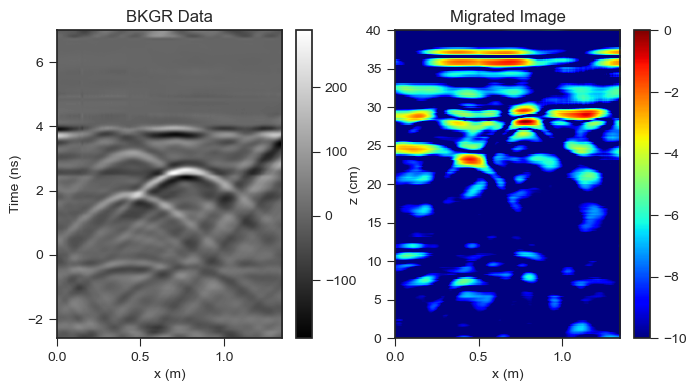

In [30]:
    
with plt.style.context('seaborn-ticks'):
    # 绘制背景数据
    plt.figure(figsize=(8, 4))

    # 子图1：正常的背景数据
    plt.subplot(121)
    plt.imshow(S.DataBKGR, extent=(S.x.min(), S.x.max(), S.t.min() * 1e9, S.t.max() * 1e9), aspect='auto', cmap='gray')
    plt.colorbar()
    plt.xlabel('x (m)')
    plt.ylabel('Time (ns)')
    plt.title('BKGR Data')
    # 子图3：正常的迁移图像
    plt.subplot(122)
    plt.imshow(10 * np.log10(S.Image), extent=(S.xC.min(), S.xC.max(), S.zC.min() * 1e2, S.zC.max() * 1e2), aspect='auto', cmap='jet', vmin=-DR, vmax=0)
    plt.colorbar()
    plt.xlabel('x (m)')
    plt.ylabel('z (cm)')
    plt.title('Migrated Image')

    plt.show()

In [6]:
# 获取输入脉冲参数（替换为实际值）
# 分割字符串
split_fn = data_source_fn.split('p')

# 获取第一个分割部分，并将其转换为浮点数
o = float(split_fn[0]) * 1e-12

Ts = S.t[1] - S.t[0]
N = 400
t = (np.arange(-N/2+1, N/2+1) * Ts)

# 模拟DOG（高斯导数）脉冲
base_gauss = normalize(np.exp(-0.5 * (t / o) ** 2))  # 0阶导数
differential = normalize(np.gradient(base_gauss))  # 1阶导数
ricker = normalize(np.gradient(differential))  # 2阶导数

# 选择Ricker波形作为匹配波形
matched_wfm = ricker
flip_matched_wfm = True  # 是否需要+/-翻转？可能需要。

if flip_matched_wfm:
    matched_wfm = -matched_wfm

take_positive_xcorr_only = True

In [7]:
# 执行匹配滤波（互相关）
S.matched_filter(matched_wfm, take_positive_xcorr_only)

# 迁移匹配滤波后的数据（用实际迁移代码替换此行）
S.migrateMF(xC, zC, display_progress_bar)

# 归一化迁移后的图像以便显示
S.ImageMF = normalize(S.ImageMF)

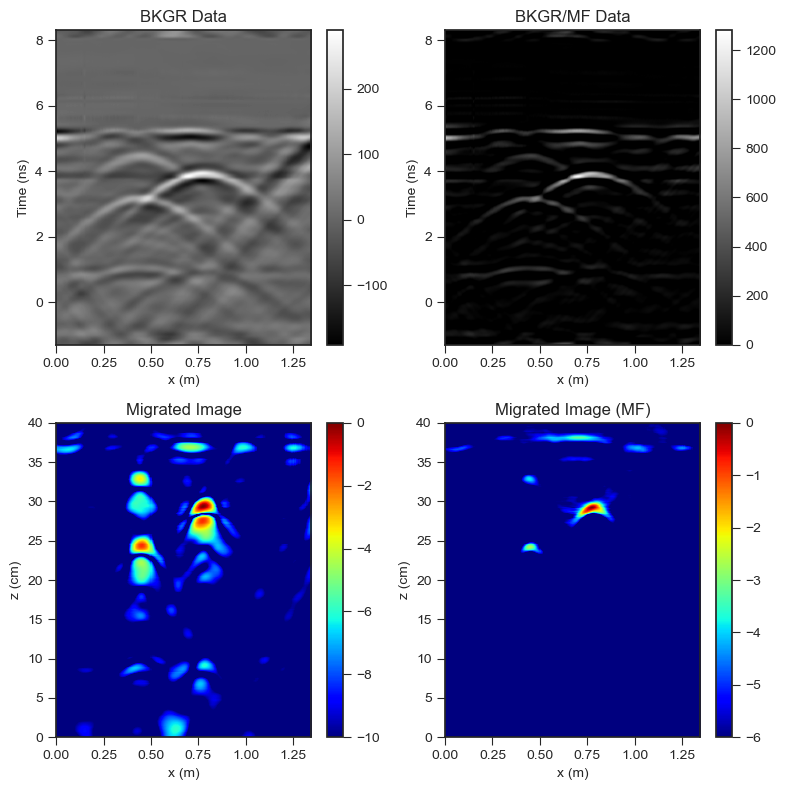

In [11]:
import matplotlib.pyplot as plt
# 设置动态范围（以dB为单位）
DR = 10
DR_matched = 6

with plt.style.context('seaborn-ticks'):
    # 绘制背景数据
    plt.figure(figsize=(8, 8))

    # 子图1：正常的背景数据
    plt.subplot(221)
    plt.imshow(S.DataBKGR, extent=(S.x.min(), S.x.max(), S.t.min() * 1e9, S.t.max() * 1e9), aspect='auto', cmap='gray')
    plt.colorbar()
    plt.xlabel('x (m)')
    plt.ylabel('Time (ns)')
    plt.title('BKGR Data')

    # 子图2：匹配滤波后的数据
    plt.subplot(222)
    plt.imshow(S.DataMF, extent=(S.x.min(), S.x.max(), S.t.min() * 1e9, S.t.max() * 1e9), aspect='auto', cmap='gray')
    plt.colorbar()
    plt.xlabel('x (m)')
    plt.ylabel('Time (ns)')
    plt.title('BKGR/MF Data')

    # 子图3：正常的迁移图像
    plt.subplot(223)
    plt.imshow(10 * np.log10(S.Image), extent=(S.xC.min(), S.xC.max(), S.zC.min() * 1e2, S.zC.max() * 1e2), aspect='auto', cmap='jet', vmin=-DR, vmax=0)
    plt.colorbar()
    plt.xlabel('x (m)')
    plt.ylabel('z (cm)')
    plt.title('Migrated Image')

    # 子图4：匹配滤波后的迁移图像
    plt.subplot(224)
    plt.imshow(10 * np.log10(S.ImageMF), extent=(S.xC.min(), S.xC.max(), S.zC.min() * 1e2, S.zC.max() * 1e2), aspect='auto', cmap='jet', vmin=-DR_matched, vmax=0)
    plt.colorbar()
    plt.xlabel('x (m)')
    plt.ylabel('z (cm)')
    plt.title('Migrated Image (MF)')

    plt.tight_layout()
    plt.show()



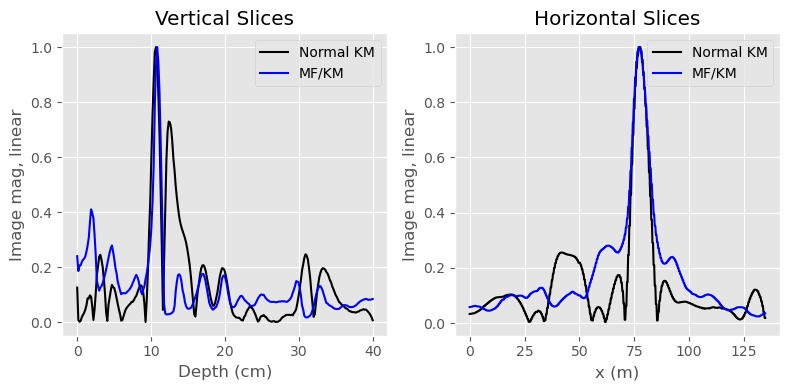

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from find_image_resolution_slices import find_image_resolution_slices

# 获取分辨率切片
vslice, hslice = find_image_resolution_slices(S.Image)
vslice_MF, hslice_MF = find_image_resolution_slices(S.ImageMF)

# 移除 find_image_resolution_slices 插入的 NaN 值
vslice = vslice[~np.isnan(vslice)]
hslice = hslice[~np.isnan(hslice)]
vslice_MF = vslice_MF[~np.isnan(vslice_MF)]
hslice_MF = hslice_MF[~np.isnan(hslice_MF)]

with plt.style.context('ggplot'):
    # 垂直切片
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.plot(S.zC * 1e2, vslice, 'k')
    plt.plot(S.zC * 1e2, vslice_MF, 'b')
    plt.xlabel('Depth (cm)')
    plt.ylabel('Image mag, linear')
    plt.legend(['Normal KM', 'MF/KM'])
    plt.title('Vertical Slices')

    # 水平切片
    plt.subplot(122)
    plt.plot(S.xC * 1e2, hslice, 'k')
    plt.plot(S.xC * 1e2, hslice_MF, 'b')
    plt.xlabel('x (m)')
    plt.ylabel('Image mag, linear')
    plt.legend(['Normal KM', 'MF/KM'])
    plt.title('Horizontal Slices')

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
# from progressbar import ProgressBar
perform_timing_test = True
# 如果 perform_timing_test 为 True，进行时间测试
if perform_timing_test:
    # 获取数据
    D = S.DataBKGR
    er = S.er
    tx_pos = S.tx_pos
    rx_pos = S.rx_pos
    h = S.h
    t = S.t
    x = S.x

    # 测量时间所需的像素宽度范围
    Nt = 30
    pixel_widths = np.logspace(np.log10(2e-2), np.log10(0.5e-3), Nt)
    times = np.zeros(Nt)

    for ii in range(Nt):
        # 定义 xC 和 zC 的像素宽度
        pixel_width = pixel_widths[ii]
        xC = np.arange(0, max(x), pixel_width)
        zC = np.arange(1e-3, 40e-2, pixel_width)

        start_time = time.time()

        # 调用迁移函数，替换为实际的迁移函数
        I = Bscan_migration_v3(D, h, er, t, x, tx_pos, rx_pos, xC, zC, 0)

        end_time = time.time()
        times[ii] = end_time - start_time


    # 绘制时间测试结果
    plt.figure()
    plt.semilogx(pixel_widths * 1e3, times, 'kx-')
    plt.xlabel('Pixel width (mm)')
    plt.ylabel('Time taken (s)')
    plt.grid(True)
    plt.show()
